# Natural Scenes Image Classification

## Menyiapkan Library yang Dibutuhkan

In [1]:
import tensorflow as tf
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_url = 'https://github.com/wildanmjjhd29/Natural-Scenes-Image-Classification/releases/download/v1.0/Natural_Scenes.zip'
urllib.request.urlretrieve(data_url, 'Natural_Scenes.zip')
local_file = 'Natural_Scenes.zip'
zip_ref = zipfile.ZipFile(local_file,'r')
zip_ref.extractall('data/')
zip_ref.close()

In [3]:
train_dir = '/content/data/seg_train/seg_train'
validation_dir = '/content/data/seg_test/seg_test'

In [4]:
os.listdir(train_dir)

['glacier', 'forest', 'mountain', 'buildings', 'street', 'sea']

In [5]:
os.listdir(validation_dir)

['glacier', 'forest', 'mountain', 'buildings', 'street', 'sea']

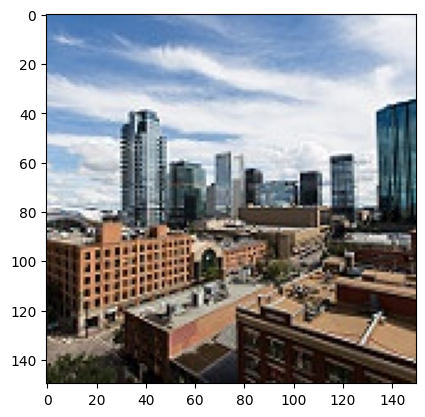

In [6]:
plt.imshow(mpimg.imread('/content/data/seg_train/seg_train/buildings/10006.jpg'))

## Menerapkan Augmentasi Gambar

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 100,
    class_mode = 'sparse',
    target_size = (150,150)
)

Found 14034 images belonging to 6 classes.


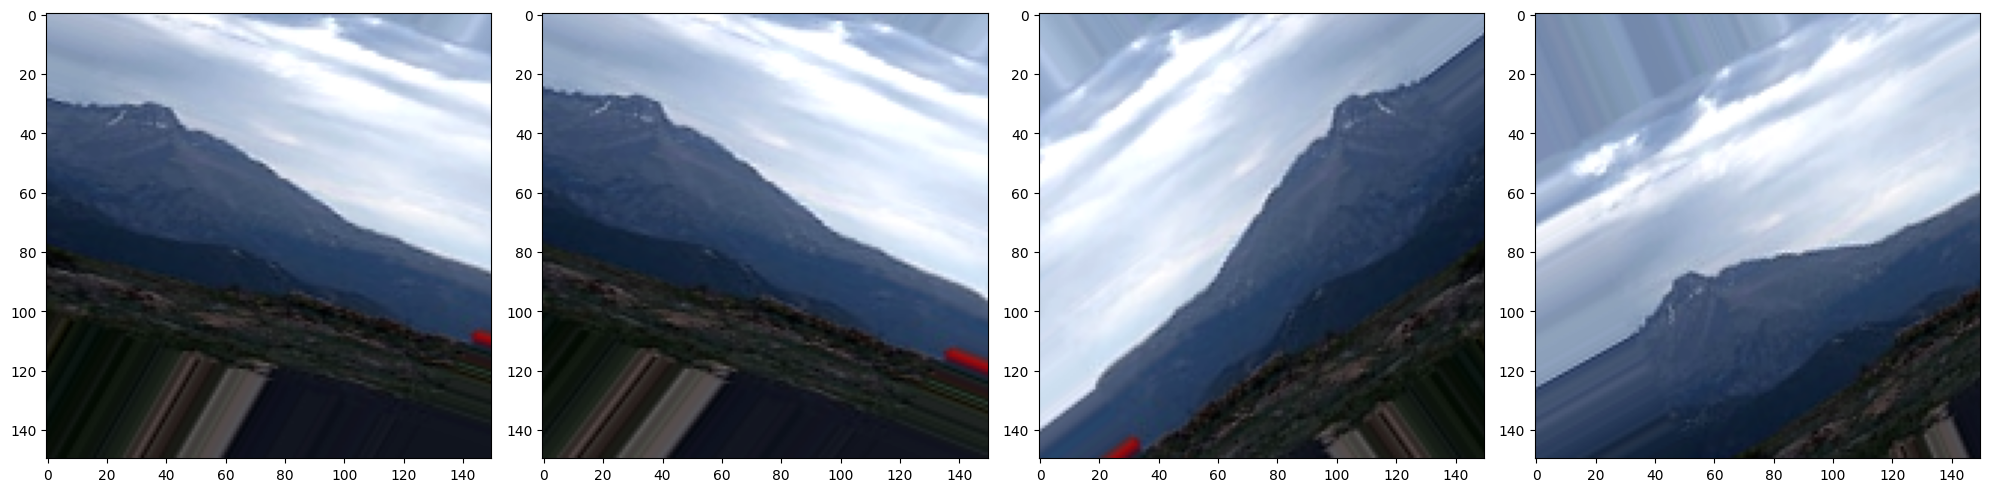

In [8]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1, len(images_arr), figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_generator[19][0][0] for i in range(4)]
plotImages(augmented_images)

In [9]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 100,
    class_mode = 'sparse',
    target_size = (150,150)
)

Found 3000 images belonging to 6 classes.


## Membuat Model

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', input_shape = (150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [11]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 30,
    epochs = 50,
    validation_steps = 10,
    batch_size = 32,
    verbose = 2,
    callbacks=[callbacks]
)

In [21]:
# Testing model
model.evaluate(validation_generator)

30/30 [==============================] - 3s 99ms/step - loss: 0.5391 - accuracy: 0.8130


[0.5391043424606323, 0.8130000233650208]

In [18]:
def plot_acc_loss(history):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_title('Loss')
  ax[0].plot(history.epoch, history.history['loss'],label = 'Train Loss')
  ax[0].plot(history.epoch, history.history['val_loss'],label = 'Valid Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(history.epoch, history.history['accuracy'],label = 'Train Accuracy')
  ax[1].plot(history.epoch, history.history['val_accuracy'],label = 'Valid Accuracy')
  ax[1].legend()

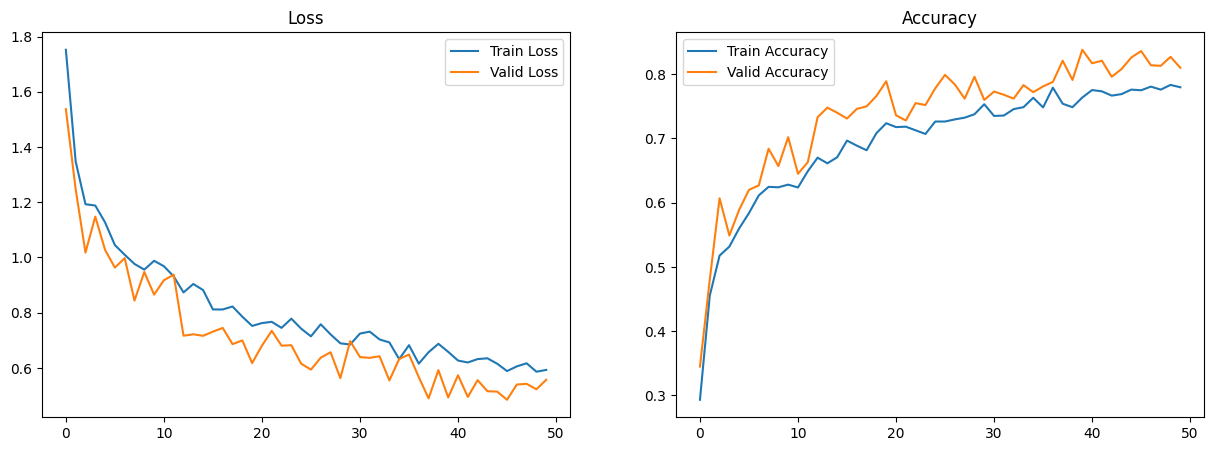

In [19]:
plot_acc_loss(history)

In [20]:
print(train_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [26]:
def predict_image_class(model, file_path):
    img = image.load_img(file_path, target_size=(150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    plt.imshow(mpimg.imread(file_path))
    plt.show()
    if classes[0][0] == 1:
        print('Buildings')
    elif classes[0][1] == 1:
        print('Forest')
    elif classes[0][2] == 1:
        print('Glacier')
    elif classes[0][3] == 1:
        print('Mountain')
    elif classes[0][4] == 1:
        print('Sea')
    elif classes[0][5] == 1:
        print('Street')
    else:
        print('Unknown')

1/1 [==============================] - 0s 18ms/step


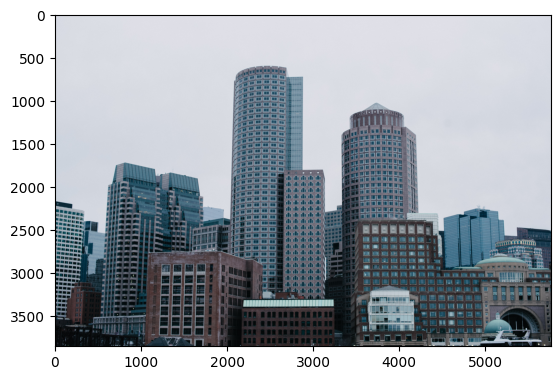

Buildings


In [36]:
predict_image_class(model,'/content/alice-donovan-rouse-tMHAmxLyzvA-unsplash.jpg')

1/1 [==============================] - 0s 19ms/step


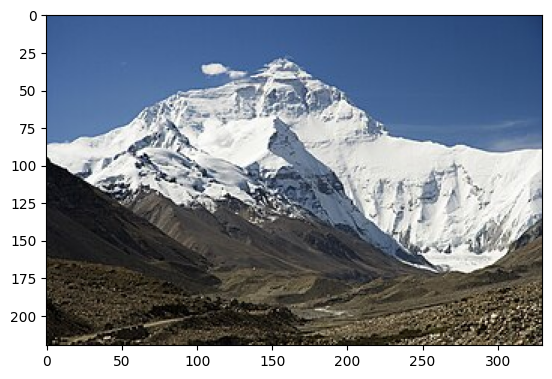

Mountain


In [30]:
predict_image_class(model,'/content/gunung.jpg')

1/1 [==============================] - 0s 32ms/step


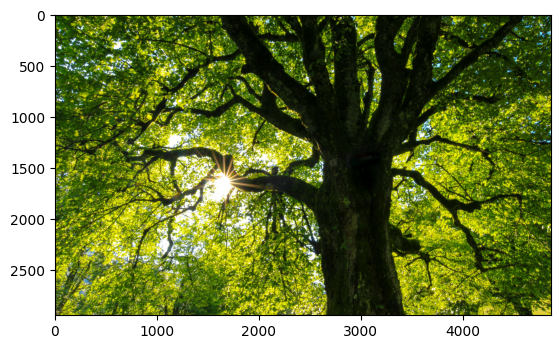

Forest


In [37]:
predict_image_class(model,'/content/jan-huber-4OhFZSAT3sw-unsplash.jpg')